In [1]:
# !pip install statsmodels

In [2]:
#Make sure to run this file in a tensorflow compatible environment
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import STL
import matplotlib
import math
from statsmodels.tsa.ar_model import AutoReg as AR
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,GRU , Dense



In [3]:
df1 = pd.read_csv('KwhConsumptionBlower78_1.csv')
df2 = pd.read_csv('KwhConsumptionBlower78_2.csv')
df3 = pd.read_csv('KwhConsumptionBlower78_3.csv')

In [4]:
#Removing the first garbage column
df1 = df1.iloc[:,1:]
df2 = df2.iloc[:,1:]
df3 = df3.iloc[:,1:]

In [5]:
df1['Timestamp'] = pd.to_datetime(df1['TxnDate'] + ' ' + df1['TxnTime'])
df1 = df1.iloc[:,2:]
df1 = df1.sort_values(by='Timestamp')

df2['Timestamp'] = pd.to_datetime(df2['TxnDate'] + ' ' + df2['TxnTime'])
df2 = df2.iloc[:,2:]
df2 = df2.sort_values(by='Timestamp')

df3['Timestamp'] = pd.to_datetime(df3['TxnDate'] + ' ' + df3['TxnTime'])
df3 = df3.iloc[:,2:]
df3 = df3.sort_values(by='Timestamp')

In [6]:
df1.to_csv("TimeStampedData1.csv", index=False)
df2.to_csv("TimeStampedData2.csv", index=False)
df3.to_csv("TimeStampedData3.csv", index=False)

In [7]:
data1 = pd.read_csv("TimeStampedData1.csv")
data2 = pd.read_csv("TimeStampedData2.csv")
data3 = pd.read_csv("TimeStampedData3.csv")


In [8]:
data1
df_combined = pd.concat([data1, data2, data3], ignore_index=True)
data1 = df_combined

In [9]:

data1["Timestamp"] = pd.to_datetime(data1["Timestamp"])
#Flooring the hours and getting the mean power consumption in every hour
data1["Hour"] = data1["Timestamp"].dt.floor("H") 
# Group by the floored hour and take the mean
hourly_mean = data1.groupby("Hour")["Consumption"].mean().reset_index()


hourly_mean.set_index("Hour", inplace=True)
hourly_mean = hourly_mean.asfreq("H")
hourly_mean["Consumption"] = hourly_mean["Consumption"].interpolate(method="time")
hourly_mean


C:\Users\preet\AppData\Local\Temp\ipykernel_10616\501330433.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data1["Hour"] = data1["Timestamp"].dt.floor("H")
C:\Users\preet\AppData\Local\Temp\ipykernel_10616\501330433.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_mean = hourly_mean.asfreq("H")


,Consumption
Hour,
2022-01-01 00:00:00,0.967000
2022-01-01 01:00:00,1.377000
2022-01-01 02:00:00,1.485000
2022-01-01 03:00:00,0.929333
2022-01-01 04:00:00,0.922667
...,...
2022-02-28 19:00:00,0.968000
2022-02-28 20:00:00,0.932000
2022-02-28 21:00:00,0.960000


# EDA(Exploratory Data Analysis)

In [10]:
hourly_mean['Consumption'].describe()

count    1416.000000
mean        2.905789
std         2.984759
min         0.734000
25%         0.966000
50%         1.369000
75%         4.294500
max        27.284000
Name: Consumption, dtype: float64

## Line Plot

Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1556 ticks ([18990.083333333332, ..., 19054.875]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1

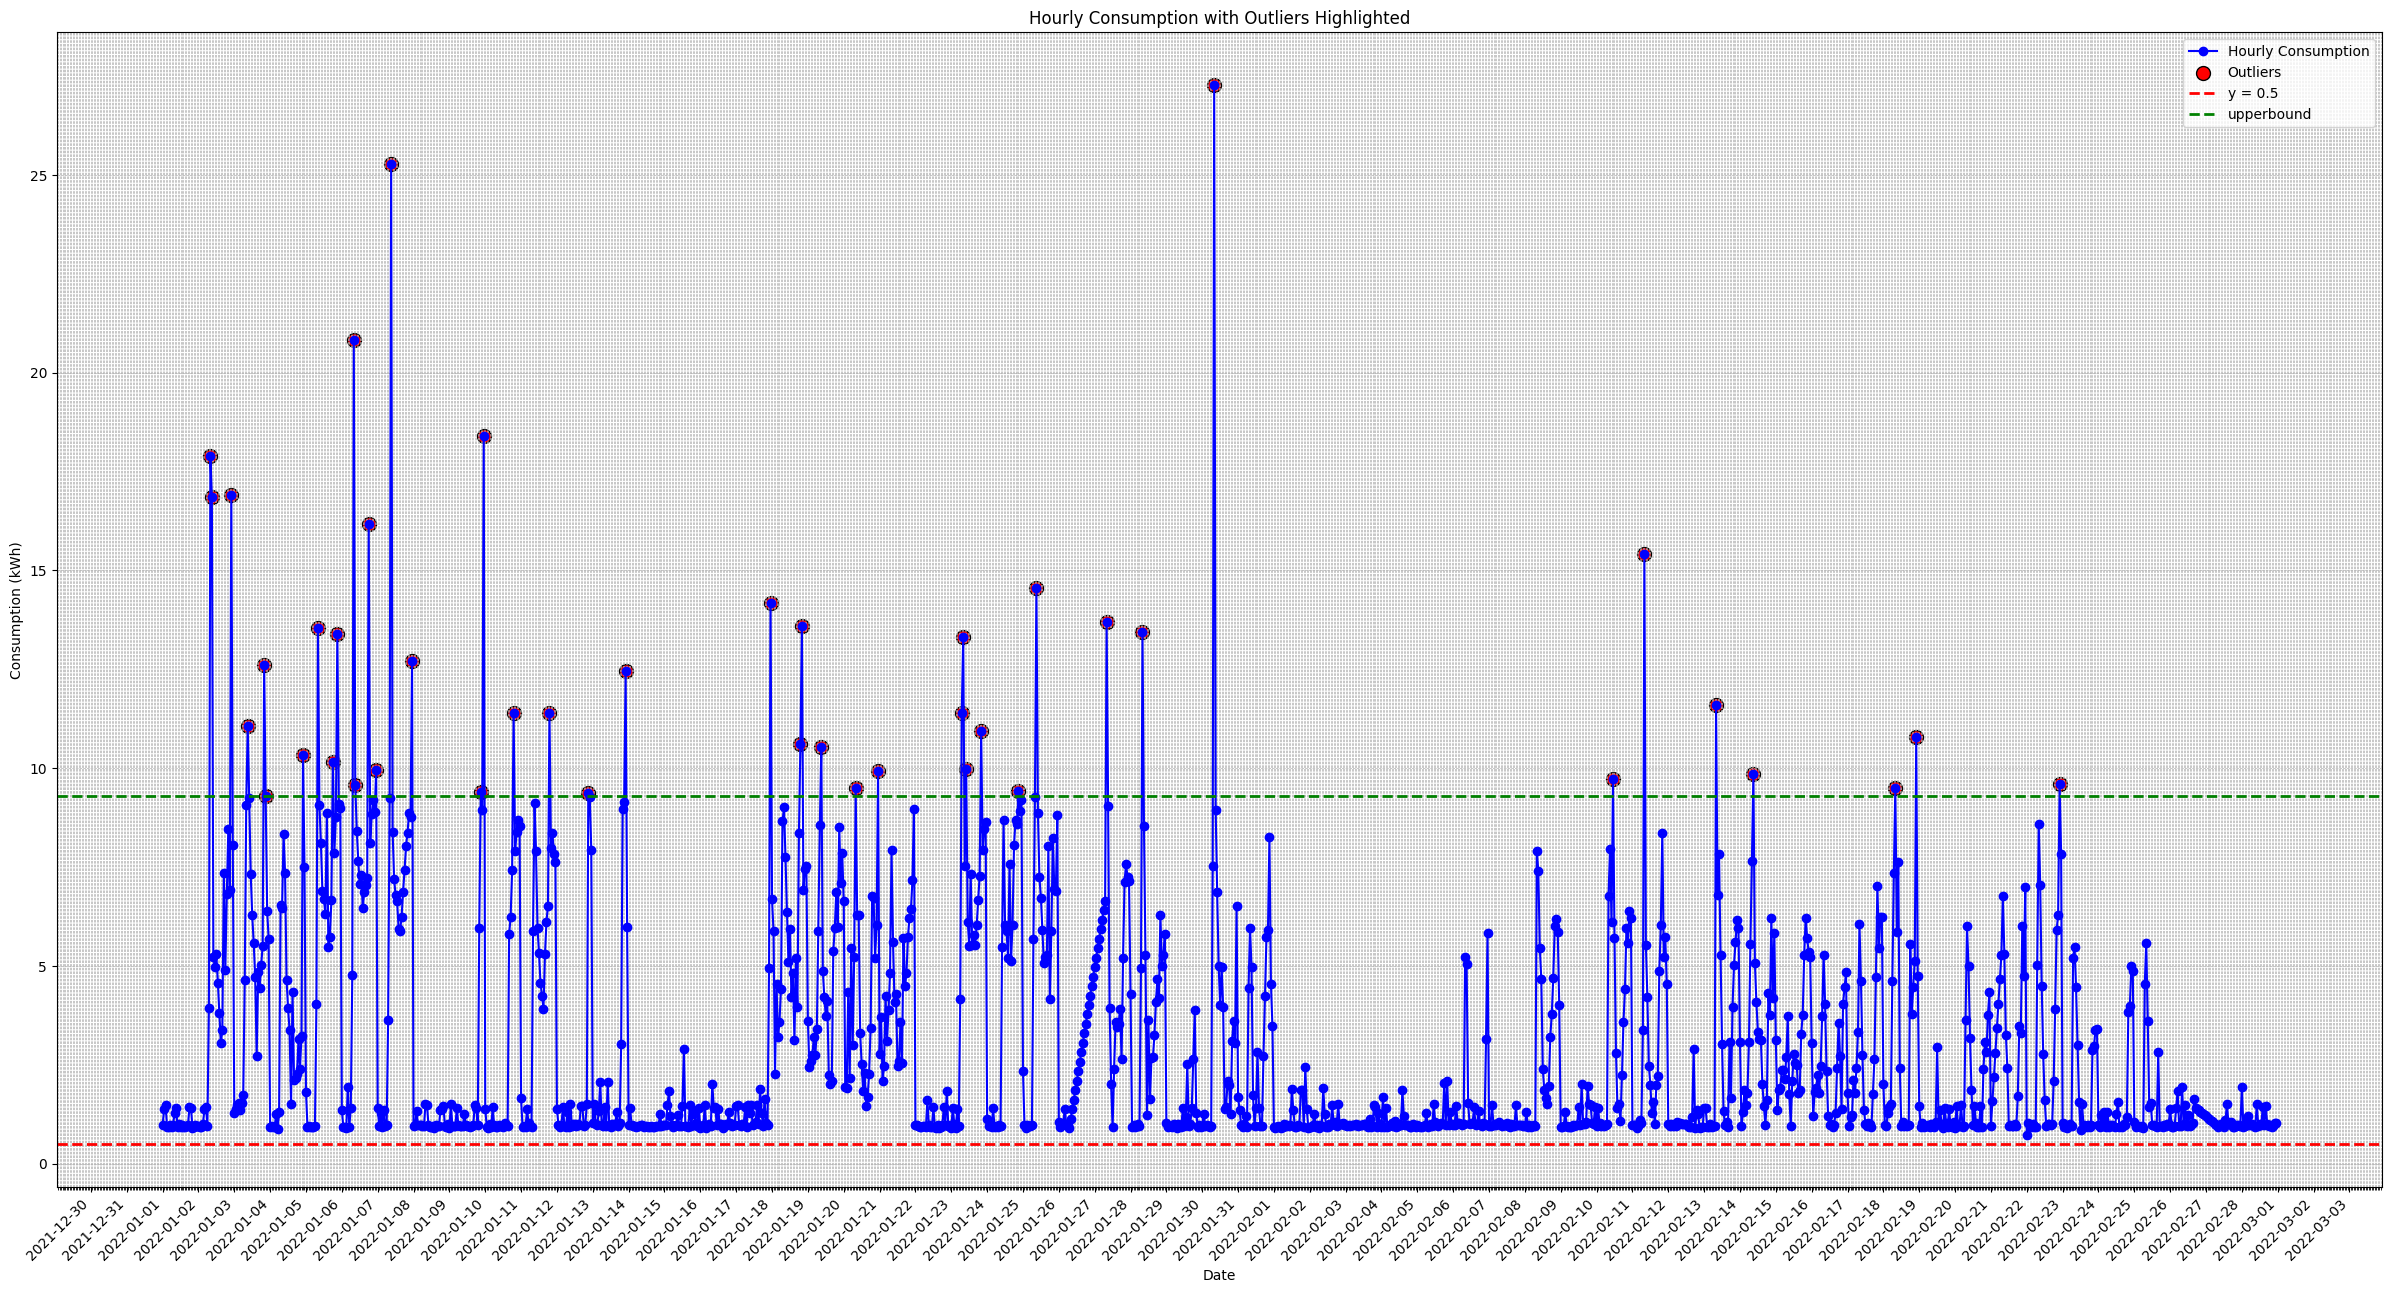

In [11]:
Q1 = hourly_mean["Consumption"].quantile(0.25)
Q3 = hourly_mean["Consumption"].quantile(0.75)
IQR = Q3 - Q1

ticker.MaxNLocator.MAXTICKS = 2000  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (hourly_mean["Consumption"] < lower_bound) | (hourly_mean["Consumption"] > upper_bound)

plt.figure(figsize=(30, 15))

plt.plot(hourly_mean.index, hourly_mean["Consumption"], marker='o', label="Hourly Consumption", color="blue")

plt.scatter(hourly_mean.index[outliers], hourly_mean["Consumption"][outliers], 
            color="red", s=100, label="Outliers", edgecolors="black")


plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="y = 0.5")
plt.axhline(y=upper_bound, color='green', linestyle='--', linewidth=2, label="upperbound")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  
ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))  

plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.title("Hourly Consumption with Outliers Highlighted")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()





## Histogram

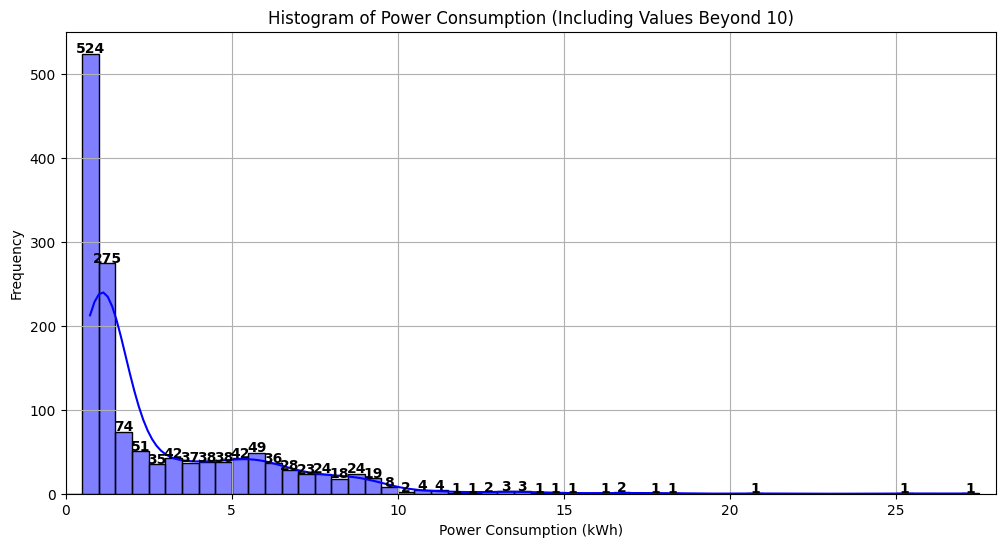

In [12]:

custom_bins = np.arange(0, max(hourly_mean["Consumption"]) + 0.5, 0.5) 
counts, bin_edges = np.histogram(hourly_mean["Consumption"], bins=custom_bins)

plt.figure(figsize=(12, 6))
ax = sns.histplot(hourly_mean["Consumption"], bins=custom_bins, kde=True, color='blue')


for count, edge in zip(counts, bin_edges[:-1]):
    if count > 0: 
        plt.text(edge + 0.25, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')


plt.xlim(0, max(bin_edges) + 0.5) 

plt.xlabel("Power Consumption (kWh)")
plt.ylabel("Frequency")
plt.title("Histogram of Power Consumption (Including Values Beyond 10)")
plt.grid(True)
plt.savefig("histogram.png")
plt.show()


## Box Plots
### although we see many outliers we can't really ignore them as per the given problem machine just might have been used "more" during that time

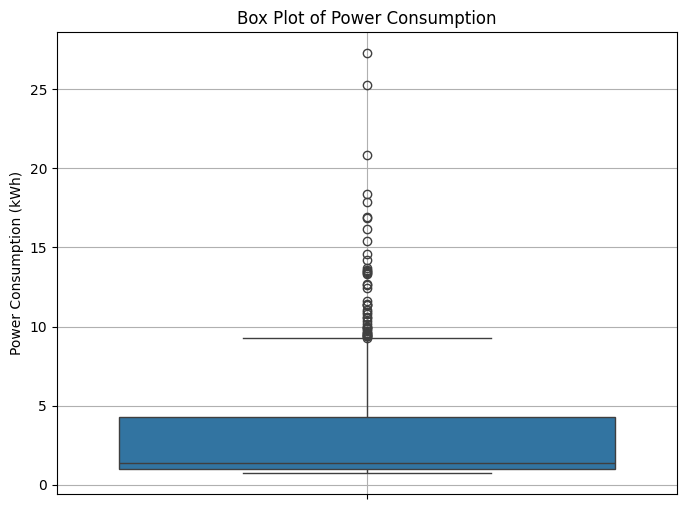

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=hourly_mean["Consumption"])

plt.ylabel("Power Consumption (kWh)")
plt.title("Box Plot of Power Consumption")
plt.grid(True)
# plt.savefig('boxplot.png')
plt.show()

 ## Rolling Average and Standard Deviation

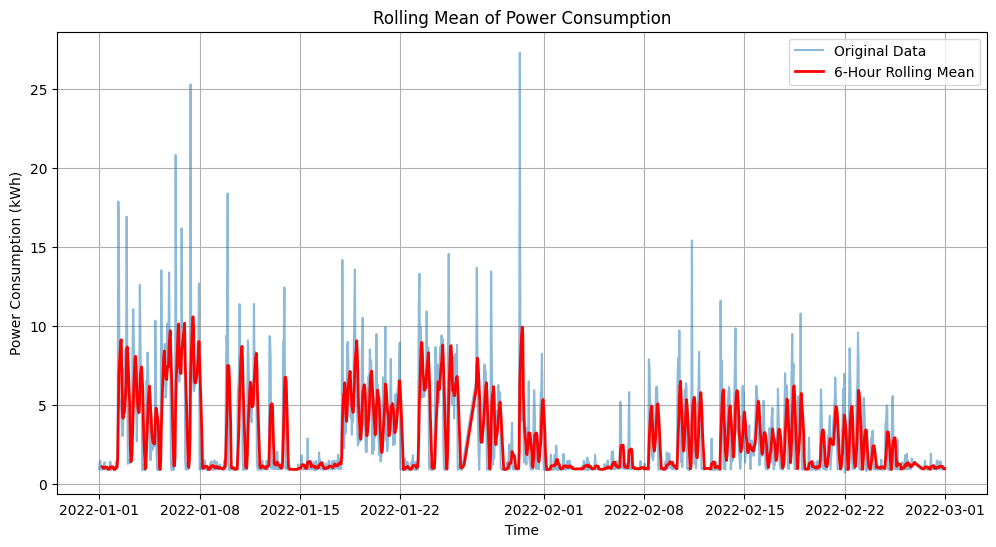

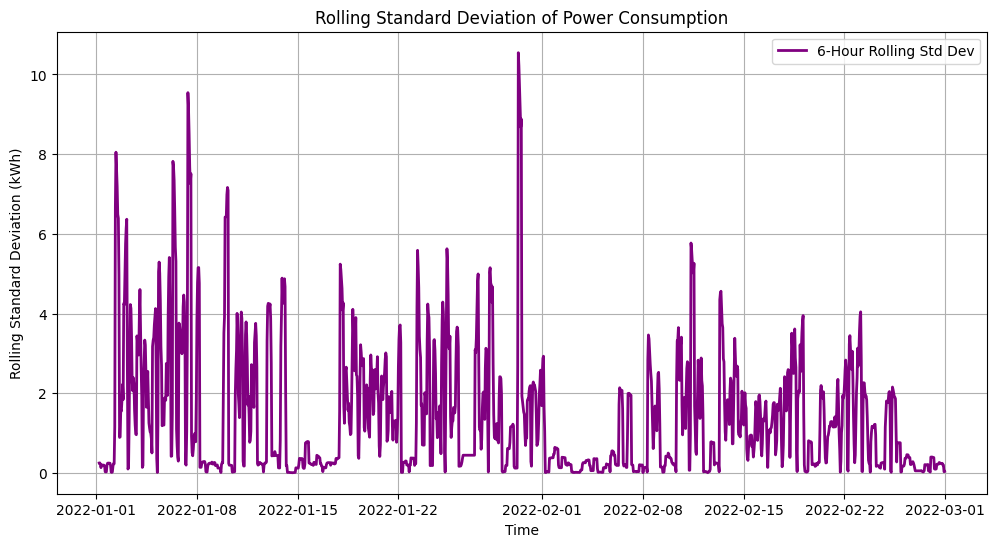

In [14]:
#6 hour window
hourly_mean["Rolling_Mean"] = hourly_mean["Consumption"].rolling(window=6).mean()


plt.figure(figsize=(12, 6))
plt.plot(hourly_mean.index, hourly_mean["Consumption"], label="Original Data", alpha=0.5)
plt.plot(hourly_mean.index, hourly_mean["Rolling_Mean"], label="6-Hour Rolling Mean", color='red', linewidth=2)


plt.xlabel("Time")
plt.ylabel("Power Consumption (kWh)")
plt.title("Rolling Mean of Power Consumption")
plt.legend()
plt.grid(True)
plt.savefig("Rolling_mean.png")
plt.show()



hourly_mean["Rolling_Std"] = hourly_mean["Consumption"].rolling(window=6).std()

plt.figure(figsize=(12, 6))
plt.plot(hourly_mean.index, hourly_mean["Rolling_Std"], label="6-Hour Rolling Std Dev", color='purple', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Rolling Standard Deviation (kWh)")
plt.title("Rolling Standard Deviation of Power Consumption")
plt.legend()
plt.grid(True)

plt.savefig("Rollin_std.png")
plt.show()

hourly_mean = hourly_mean.drop(columns=["Rolling_Mean", "Rolling_Std"])

## Seasonal Decomposition

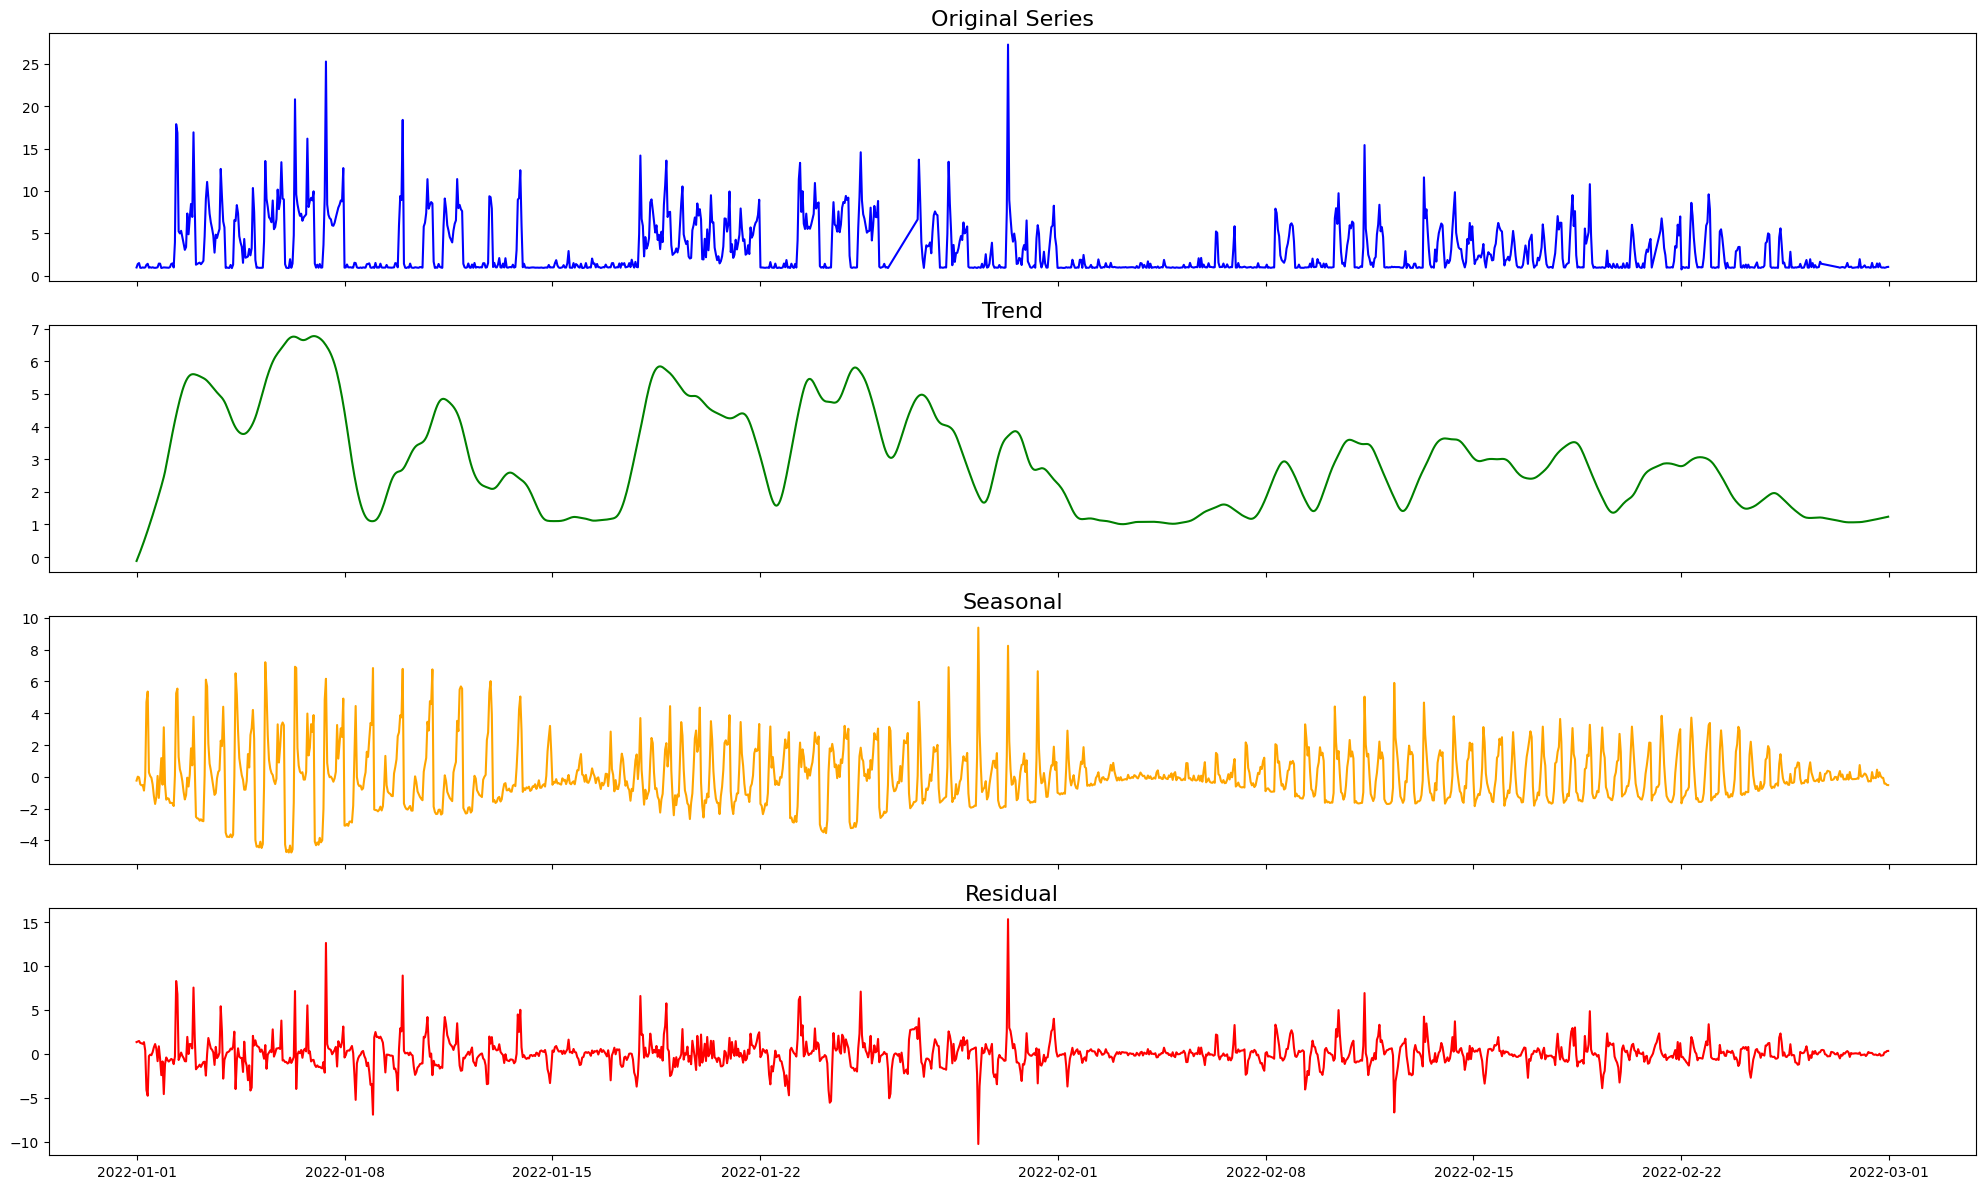

In [15]:


data1 = hourly_mean  

stl = STL(data1)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

axes[0].plot(data1, color='blue')
axes[0].set_title('Original Series', fontsize=16)

axes[1].plot(trend, color='green')
axes[1].set_title('Trend', fontsize=16)

axes[2].plot(seasonal, color='orange')
axes[2].set_title('Seasonal', fontsize=16)

axes[3].plot(resid, color='red')
axes[3].set_title('Residual', fontsize=16)

plt.tight_layout()
# plt.savefig('stl_decomposition.png', dpi=300)
plt.show()


### Performing the Augmented Dickey Fuller Test ()

In [16]:
#Augmented Dickey Fuller Test

result = adfuller(hourly_mean["Consumption"])

print("Augmented Dickey-Fuller Test Results:")
print(f"p-value: {result[1]}")

alpha = 0.05  # 5% significance level
if result[1] < alpha:
    print("\nThe series is likely stationary (reject H0).")
else:
    print("\nThe series is likely non-stationary (fail to reject H0).")

Augmented Dickey-Fuller Test Results:
p-value: 0.0011694302777341984

The series is likely stationary (reject H0).


## PACF(Partial AutoCorrelation)

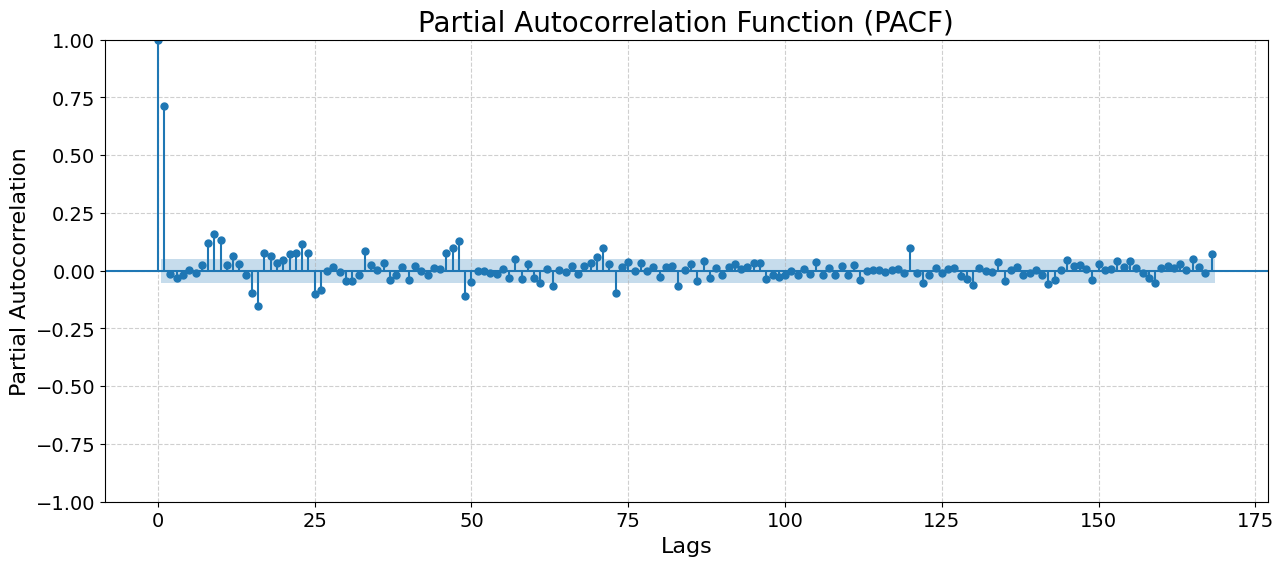

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))  

plot_pacf(hourly_mean["Consumption"], lags=168, ax=ax) 

ax.grid(True, linestyle='--', alpha=0.6)
ax.set_title("Partial Autocorrelation Function (PACF)", fontsize=20)
ax.set_xlabel("Lags", fontsize=16)
ax.set_ylabel("Partial Autocorrelation", fontsize=16)

ax.tick_params(axis='both', labelsize=14)
# plt.savefig("pacf.png")

plt.show()

### AutoCorrelation Function

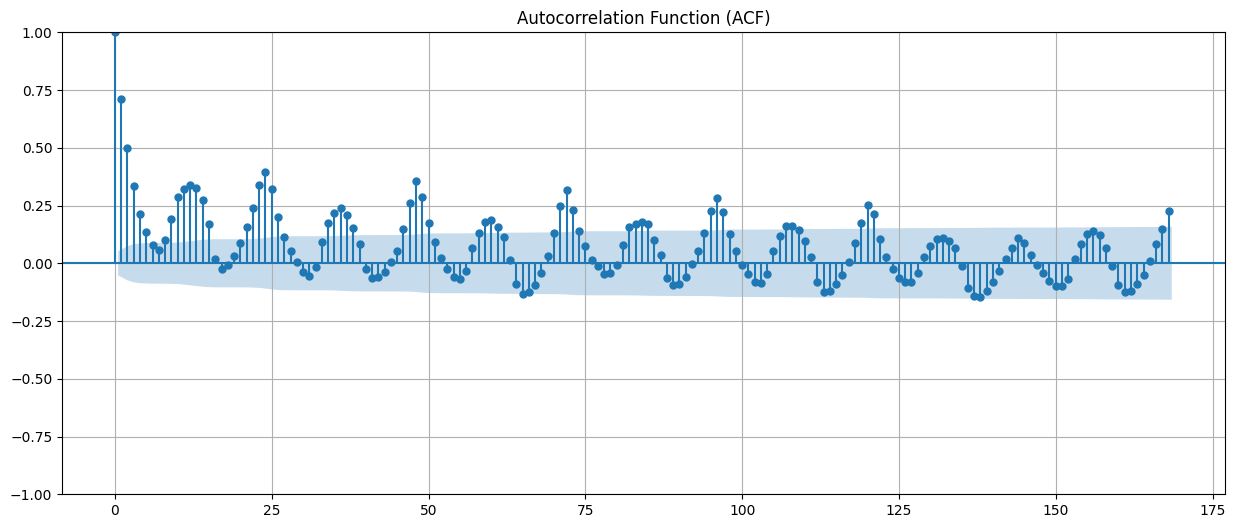

In [18]:


fig, ax = plt.subplots(figsize=(15, 6))  

plot_acf(hourly_mean["Consumption"], lags=168, ax=ax)

ax.set_title("Autocorrelation Function (ACF)")
plt.grid()

#plt.savefig("acf.png")
plt.show()


## Rolling Forecasts(Step by Step Predictions)

In [19]:
train_size = int(len(hourly_mean) * 0.8)
train = hourly_mean.iloc[:train_size]
test = hourly_mean.iloc[train_size:]


#### Auto Regression (AR model)

In [20]:
lag_arr = [1,2,3,4,6,9,12,16,24,30,40]
mape_arr = []
rmse_arr= []

for lag in lag_arr:

    data=hourly_mean
    
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    
    #Fitting the model
    model = sm.tsa.SARIMAX(
        train,
        order=(lag, 0,0),
        seasonal_order=(0, 0, 0,0),
    )
    res = model.fit(disp=False)
    

    res_ext = res.append(test)
    

    pred = res_ext.get_prediction(
        start=test.index[0],
        end=test.index[-1],
        dynamic=False
    )
    y_pred = pred.predicted_mean
    
    #Evaluation
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mape = mean_absolute_percentage_error(test, y_pred)

    mape_arr.append(mape)
    rmse_arr.append(rmse)
    print(f"\nFor lag = {lag}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"MAPE : {mape*100} %")



For lag = 1
Test RMSE: 1.3483
MAPE : 36.976973134474264 %

For lag = 2
Test RMSE: 1.3619
MAPE : 36.74148461755845 %

For lag = 3
Test RMSE: 1.3680
MAPE : 36.93126173892341 %

For lag = 4
Test RMSE: 1.3674
MAPE : 37.294920248972446 %

For lag = 6
Test RMSE: 1.3629
MAPE : 37.66091148905169 %

For lag = 9
Test RMSE: 1.2559
MAPE : 38.68047631104885 %

For lag = 12
Test RMSE: 1.2113
MAPE : 37.53158171269388 %

For lag = 16
Test RMSE: 1.1984
MAPE : 40.195601948970264 %

For lag = 24
Test RMSE: 1.1713
MAPE : 43.73498594357316 %

For lag = 30
Test RMSE: 1.1677
MAPE : 43.17553308601989 %

For lag = 40
Test RMSE: 1.1767
MAPE : 44.69600247828055 %


Test RMSE: 1.2113
MAPE : 37.53158171269388 %


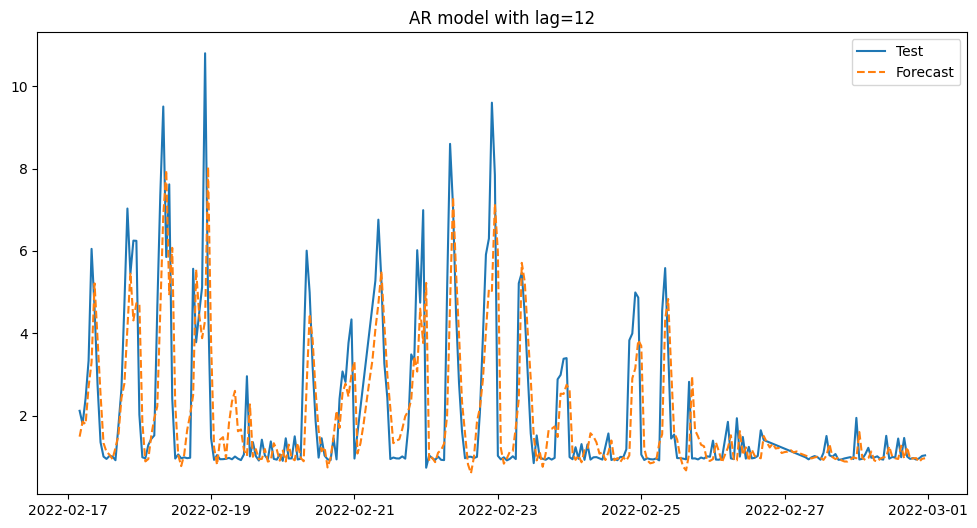

In [21]:
#Plotting the best one
data=hourly_mean
    
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

model = sm.tsa.SARIMAX(
    train,
    order=(12, 0,0),
    seasonal_order=(0, 0, 0,0),
)
res = model.fit(disp=False)
res_ext = res.append(test)

pred = res_ext.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean

rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title("AR model with lag=12")
#plt.savefig("arbest")
plt.show()

### Moving Average (MA) Model

In [22]:
#Running this may take some time
ma_order_arr = [1,2,3,4,6,9,12,16,24,30]
mape_arr = []
rmse_arr = []




for ma_order in ma_order_arr:

    data=hourly_mean
    
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    
    #Fitting the Model
    model = sm.tsa.SARIMAX(
        train,
        order=(0, 0, ma_order),
        seasonal_order=(0, 0, 0,0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    res_ext = res.append(test)
    
    pred = res_ext.get_prediction(
        start=test.index[0],
        end=test.index[-1],
        dynamic=False
    )
    y_pred = pred.predicted_mean
    

    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mape = mean_absolute_percentage_error(test, y_pred)

    mape_arr.append(mape)
    rmse_arr.append(rmse)
    
    print(f"\nFor MA order = {ma_order}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"MAPE : {mape*100} %")


For MA order = 1
Test RMSE: 1.9069
MAPE : 65.19173501333765 %

For MA order = 2
Test RMSE: 1.5897
MAPE : 55.04006133101081 %

For MA order = 3
Test RMSE: 1.4879
MAPE : 50.11858774999857 %

For MA order = 4
Test RMSE: 1.4231
MAPE : 46.64145322131535 %

For MA order = 6
Test RMSE: 1.3703
MAPE : 45.84185356934045 %

For MA order = 9
Test RMSE: 1.3732
MAPE : 46.472657252373764 %

For MA order = 12
Test RMSE: 1.3729
MAPE : 44.952390206328914 %

For MA order = 16
Test RMSE: 1.2929
MAPE : 38.552010581600186 %

For MA order = 24
Test RMSE: 1.2630
MAPE : 39.71477553776494 %

For MA order = 30
Test RMSE: 1.2478
MAPE : 43.036236064966324 %


Test RMSE: 1.2929
MAPE : 38.552010581600186 %


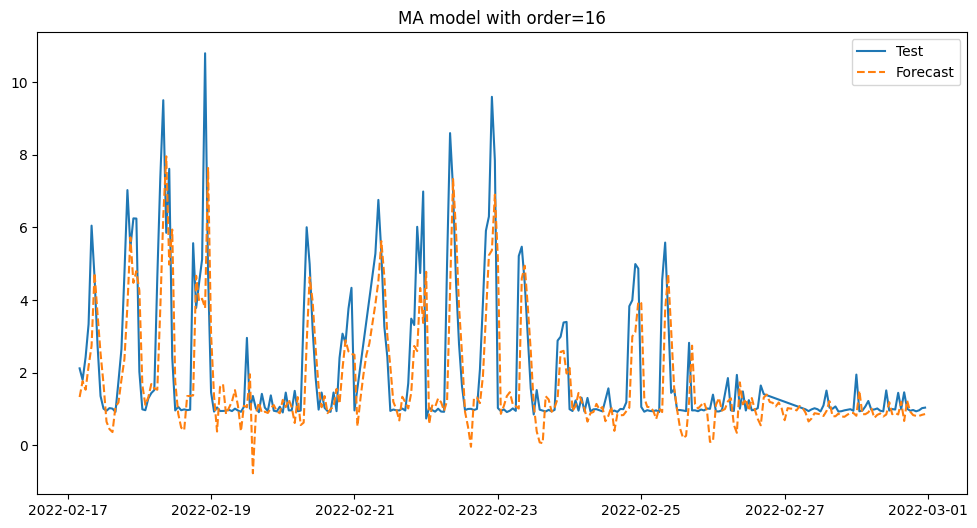

In [23]:
#Plotting the best MA model

data=hourly_mean
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

model = sm.tsa.SARIMAX(
    train,
    order=(0, 0, 16),
    seasonal_order=(0, 0, 0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
res_ext = res.append(test)

pred = res_ext.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean

rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)

mape_arr.append(mape)
rmse_arr.append(rmse)

print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")

plt.figure(figsize=(12, 6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title("MA model with order=16")
#plt.savefig("bestMA")
plt.show()

### Auto Regressive Integrated Moving Average (ARIMA) Model

#### Performing Grid Search for best parameters

In [24]:
#CAUTION : Running the grid Search on ARIMA takes significant time
p_arr = [1,2,3,4,6,9,12,16,24]
q_arr = [1,2,3,4,6,9,12,16]
diff_arr = [0,1]

data=hourly_mean
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
best_rmse = 99999
best_mape = 99999
best_rmse_order = (0,0,0)
best_mape_order = (0,0,0)

for p in p_arr:
    for d in diff_arr:
        for q in q_arr:

            
            model = sm.tsa.SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(0, 0, 0,0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False, maxiter=1000)
            
            res_ext = res.append(test)
            
            pred = res_ext.get_prediction(
                start=test.index[0],
                end=test.index[-1],
                dynamic=False
            )
            y_pred = pred.predicted_mean
            
            rmse = np.sqrt(mean_squared_error(test, y_pred))
            mape = mean_absolute_percentage_error(test, y_pred)
            print(f"\nFor order = {p} - {d} - {q}")
            print(f"Test RMSE: {rmse:.4f}")
            print(f"MAPE : {mape*100} %")

            if(best_rmse > rmse):
                best_rmse = rmse
                best_rmse_order = (p,d,q)

            if(best_mape > mape):
                best_mape = mape
                best_mape_order = (p,d,q)
            


For order = 1 - 0 - 1
Test RMSE: 1.3652
MAPE : 36.676479860211 %

For order = 1 - 0 - 2
Test RMSE: 1.3753
MAPE : 37.38071884902975 %

For order = 1 - 0 - 3
Test RMSE: 1.3106
MAPE : 47.31786997402924 %

For order = 1 - 0 - 4
Test RMSE: 1.2828
MAPE : 45.79541156083583 %

For order = 1 - 0 - 6
Test RMSE: 1.2738
MAPE : 45.54029602477048 %

For order = 1 - 0 - 9
Test RMSE: 1.2689
MAPE : 44.5288076529162 %

For order = 1 - 0 - 12
Test RMSE: 1.2564
MAPE : 41.98267859892258 %

For order = 1 - 0 - 16
Test RMSE: 1.2265
MAPE : 44.62019781261738 %

For order = 1 - 1 - 1
Test RMSE: 1.2938
MAPE : 49.17976058955474 %

For order = 1 - 1 - 2
Test RMSE: 1.2882
MAPE : 48.96348123939561 %

For order = 1 - 1 - 3
Test RMSE: 1.2798
MAPE : 48.40164547430487 %

For order = 1 - 1 - 4
Test RMSE: 1.2767
MAPE : 48.04783048702694 %

For order = 1 - 1 - 6
Test RMSE: 1.2778
MAPE : 47.838085284574774 %

For order = 1 - 1 - 9
Test RMSE: 1.2634
MAPE : 45.095612472294526 %

For order = 1 - 1 - 12
Test RMSE: 1.2489
MAPE 

C:\Users\preet\anaconda3\envs\tfenv_clean\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



For order = 6 - 0 - 3
Test RMSE: 1.3201
MAPE : 50.1900026455256 %

For order = 6 - 0 - 4
Test RMSE: 1.2544
MAPE : 42.507602022890744 %

For order = 6 - 0 - 6
Test RMSE: 1.2093
MAPE : 48.479234311146755 %

For order = 6 - 0 - 9
Test RMSE: 1.2080
MAPE : 46.28000429869086 %

For order = 6 - 0 - 12
Test RMSE: 1.2338
MAPE : 49.620241588731254 %


C:\Users\preet\anaconda3\envs\tfenv_clean\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



For order = 6 - 0 - 16
Test RMSE: 1.2336
MAPE : 49.45941986179515 %

For order = 6 - 1 - 1
Test RMSE: 1.2453
MAPE : 43.77972240637075 %

For order = 6 - 1 - 2
Test RMSE: 1.2390
MAPE : 42.829038276577215 %

For order = 6 - 1 - 3
Test RMSE: 1.2947
MAPE : 47.553414617876946 %

For order = 6 - 1 - 4
Test RMSE: 1.2198
MAPE : 50.468860488790355 %

For order = 6 - 1 - 6
Test RMSE: 1.2087
MAPE : 49.067317244424515 %

For order = 6 - 1 - 9
Test RMSE: 1.2367
MAPE : 51.397886454877174 %

For order = 6 - 1 - 12
Test RMSE: 1.1896
MAPE : 47.62265846192244 %

For order = 6 - 1 - 16
Test RMSE: 1.1881
MAPE : 50.716707432184 %

For order = 9 - 0 - 1
Test RMSE: 1.2139
MAPE : 37.868269905134774 %

For order = 9 - 0 - 2
Test RMSE: 1.2384
MAPE : 51.764803498549504 %

For order = 9 - 0 - 3
Test RMSE: 1.2374
MAPE : 51.637891229389666 %

For order = 9 - 0 - 4
Test RMSE: 1.2109
MAPE : 41.9398832951952 %

For order = 9 - 0 - 6
Test RMSE: 1.2772
MAPE : 48.56688753032004 %


C:\Users\preet\anaconda3\envs\tfenv_clean\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



For order = 9 - 0 - 9
Test RMSE: 1.1830
MAPE : 47.002348190224915 %

For order = 9 - 0 - 12
Test RMSE: 1.1730
MAPE : 46.097967509732655 %


C:\Users\preet\anaconda3\envs\tfenv_clean\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_mape_order

In [ ]:
best_mape

In [ ]:
best_rmse_order

In [ ]:
best_rmse

In [ ]:
#Min MAPE ARIMA
data=hourly_mean

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

model = sm.tsa.SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0,0),
    enforce_stationarity=False,
                enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=1000)

res_ext = res.append(test)

pred = res_ext.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean


rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)
print(f"\n1- 0 -1")
print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")


plt.figure(figsize=(12, 6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title("")
#plt.savefig("MinMapeARIMA")
plt.show()

In [ ]:
#Min RMSE ARIMA
data=hourly_mean

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

model = sm.tsa.SARIMAX(
    train,
    order=(24, 1, 6),
    seasonal_order=(0, 0, 0,0),
    enforce_stationarity=False,
                enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=1000)

res_ext = res.append(test)

pred = res_ext.get_prediction(
    start=test.index[0],
    
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean


rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)
print(f"\n24-1-6")
print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")


plt.figure(figsize=(12, 6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title("")
#plt.savefig("MinMapeARIMA")
plt.show()

### Seasonal Auto Regressive Integrated Moving Average(SARIMA)

#### Performing Grid Search on SARIMA

In [ ]:
#CAUTION: Running the Grid Search on SARIMA takes significant time
p_arr = [0,1,2,3]
q_arr = [0,1,2,3]
diff_arr = [0,1]
P_arr = [0,1,2]
Q_arr = [0,1,2]
D_arr = [0,1]
m_arr = [6,12,24]


data=hourly_mean
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
best_rmse = 99999
best_mape = 99999
best_rmse_order = (0,0,0)
best_mape_order = (0,0,0)
best_rmse_order_s = (0,0,0,0)
best_mape_order_s = (0,0,0,0)

for p in p_arr:
    for d in diff_arr:
        for q in q_arr:
            for P in P_arr:
                for Q in Q_arr:
                    for D in D_arr:
                        for m in m_arr:

            
                            model = sm.tsa.SARIMAX(
                                train,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q,m),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            res = model.fit(disp=False, maxiter=1000)
                            
                            res_ext = res.append(test)
                            
                            pred = res_ext.get_prediction(
                                start=test.index[0],
                                end=test.index[-1],
                                dynamic=False
                            )
                            y_pred = pred.predicted_mean
                            
                            # Evaluate
                            rmse = np.sqrt(mean_squared_error(test, y_pred))
                            mape = mean_absolute_percentage_error(test, y_pred)
                            print(f"\nFor order = {p} - {d} - {q} , {P} - {D} - {Q}- {m}")
                            print(f"Test RMSE: {rmse:.4f}")
                            print(f"MAPE : {mape*100} %")
                
                            if(best_rmse > rmse):
                                best_rmse = rmse
                                best_rmse_order = (p,d,q)
                                best_rmse_order_s = (P,D,Q,m)
                
                            if(best_mape > mape):
                                best_mape = mape
                                best_mape_order = (p,d,q)
                                best_mape_order_s = (P,D,Q,m)
            

In [ ]:
print(f"Best RMSE : {best_rmse}, rmse_order = {best_mape_order}, {best_mape_order_s}")
print(f"Best MAPE: {best_mape}, mape_order = {best_rmse_order}, {best_rmse_order_s}")

In [ ]:
#BEST MAPE (2,0,0, 1,0,0,12)

order_t = (2,0,0)
sorder = (1,0,0,12)
            
model = sm.tsa.SARIMAX(
    train,
    order=order_t,
    seasonal_order=sorder,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=1000)

res_ext = res.append(test)

pred = res_ext.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean

rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)
print(f"\nFor order = {order_t} , {sorder}")
print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title(f"For Order {order_t}, {sorder}")
plt.savefig("SARIMAminMAPE")
plt.show()

In [ ]:
#BEST RMSE (1,0,0,2,0,2,12)

order_t = (1,0,0)
sorder = (2,0,2,12)
            
model = sm.tsa.SARIMAX(
    train,
    order=order_t,
    seasonal_order=sorder,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=1000)

res_ext = res.append(test)

#Predicting
pred = res_ext.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
y_pred = pred.predicted_mean

# Evaluating
rmse = np.sqrt(mean_squared_error(test, y_pred))
mape = mean_absolute_percentage_error(test, y_pred)
print(f"\nFor order = {order_t} , {sorder}")
print(f"Test RMSE: {rmse:.4f}")
print(f"MAPE : {mape*100} %")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Test")
plt.plot(y_pred.index, y_pred, label="Forecast", linestyle="--")
plt.legend()
plt.title(f"For Order {order_t}, {sorder}")
plt.savefig("SARIMAminRMSE")
plt.show()

### Deep Learning Models

#### All deep learning models iterate over a few architectures while also varying input sequence length, some take considerable time to run

#### Going forward, units are the number of neurons in the hidden layer and steps are the varying sequence length

#### RNNs

In [ ]:
input_data = hourly_mean["Consumption"]

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps_list = [3, 5, 6, 9, 12, 16, 24]
units_list = [24, 30, 40, 50, 64, 128]

rmse_arr4 = []
mape_arr4 = []

best_rmse = float('inf')
best_rmse_config = None

best_mape = float('inf')
best_mape_config = None
for steps in n_steps_list:
    
    X, y = create_sequences(input_data, steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train/test split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    for units in units_list:
        model = Sequential([
            SimpleRNN(units, activation='relu', input_shape=(steps, 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)

        # Predict
        y_pred = model.predict(X_test)
        y_test_orig = y_test.reshape(-1, 1)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
        mape = mean_absolute_percentage_error(y_test_orig, y_pred)

        print(f"Steps: {steps}, Units: {units}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Test MAPE: {mape * 100:.2f} %\n")

        rmse_arr4.append((steps, units, rmse))
        mape_arr4.append((steps, units, mape))

        if rmse < best_rmse:
            best_rmse = rmse
            best_rmse_config = (steps, units)

        if mape < best_mape:
            best_mape = mape
            best_mape_config = (steps, units)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(y_test_orig, label='True Consumption')
        plt.plot(y_pred, label='RNN Predictions')
        plt.legend()
        plt.title(f'RNN Forecast (Steps={steps}, Units={units})')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.show()


In [ ]:
best_rmse

In [ ]:
best_rmse_config

In [ ]:
best_mape

In [ ]:
best_mape_config

#### Stacked RNN

In [ ]:
input_data = hourly_mean["Consumption"]

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = [3, 5, 6, 9, 12, 16, 24]
units_list = [24, 30, 40, 50, 64, 128]

rmse_arr5 = []
mape_arr5 = []

best_rmse = float('inf')
best_rmse_config = None

best_mape = float('inf')
best_mape_config = None

for steps in n_steps:  # Fixed here
    X, y = create_sequences(input_data, steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train/test split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build RNN model
    for units in units_list:
        model = Sequential([
            SimpleRNN(units, activation='relu', return_sequences=True, input_shape=(steps, 1)),
            SimpleRNN(units // 2, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print(f"Steps: {steps}, Units: {units}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Test MAPE: {mape * 100:.2f} %")
        
        rmse_arr5.append((steps, units, rmse))
        mape_arr5.append((steps, units, mape))

        if rmse < best_rmse:
            best_rmse = rmse
            best_rmse_config = (steps, units)

        if mape < best_mape:
            best_mape = mape
            best_mape_config = (steps, units)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(y_test, label='True Consumption')
        plt.plot(y_pred, label='RNN Predictions')
        plt.legend()
        plt.title(f'RNN Forecast vs True Values (steps={steps}, units={units})')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.show()

print(f"Best RMSE: {best_rmse:.4f} at config: {best_rmse_config}")
print(f"Best MAPE: {best_mape * 100:.2f}% at config: {best_mape_config}")


In [ ]:
best_mape

In [ ]:
best_mape_config

In [ ]:
best_rmse

In [ ]:
best_rmse_config

#### LSTMs

In [ ]:
def create_sequences(data, seq_length):
            xs, ys = [], []
            for i in range(len(data) - seq_length):
                x = data.iloc[i:i+seq_length]
                y = data.iloc[i+seq_length]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)

In [ ]:
train_size = int(len(hourly_mean) * 0.8)
train, test = hourly_mean.iloc[:train_size], hourly_mean.iloc[train_size:]

n_steps = [3, 5, 6, 9, 12, 16, 24]
units_list = [24, 30, 40, 50, 64, 128]

rmse_arr = []
mape_arr = []

best_rmse = 99999
best_mape = 99999

best_rmse_config = None
best_mape_config = None

for sequence_len in n_steps:
    for unit in units_list:
        
        seq_length = sequence_len
        X, y = create_sequences(train, seq_length)
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        
        X_test,y_test=create_sequences(test, seq_length)
        X_test = torch.from_numpy(X_test).float()
        y_test = torch.from_numpy(y_test).float()
        
        class LSTMModel(nn.Module):
            def __init__(self, input_size=1, hidden_size=unit, num_layers=1):
                super(LSTMModel, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
                self.fc = nn.Linear(hidden_size, 1)
        
            def forward(self, x):
                h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
                c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
                out, _ = self.lstm(x, (h0, c0))
                out = self.fc(out[:, -1, :])  # Take output of last time step
                return out
        
        model = LSTMModel()
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        #Training
        epochs = 150
        for epoch in range(epochs):
            model.train()
            output = model(X)
            loss = loss_fn(output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        #Evaluation
        model.eval()
        preds = model(X_test).detach().numpy()
        mape = mean_absolute_percentage_error(preds,y_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print(f"MAPE : {mape * 100}")
        print(f"RMSE : {rmse}")

        if mape < best_mape:
            best_mape  = mape
            best_mape_config = (sequence_len, unit)
        if rmse< best_rmse:
            best_rmse = rmse
            best_rmse_config = (sequence_len, unit)
        
        # plt.figure(figsize=(12,6))
        # plt.plot(y_test, label = "Actual")
        # plt.plot(preds, label="predicted")
        
        # plt.legend()

print(f"Best RMSE config {best_rmse_config} with rmse : {best_rmse}")
print(f"Best MAPE config {best_mape_config} with mape: {best_mape}")


#### GRUs

In [ ]:


scaled = hourly_mean["Consumption"].values

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps_list = [3, 5, 6, 9, 12, 16, 24]
units_list = [24, 30, 40, 50, 64, 128]

rmse_arr_gru = []
mape_arr_gru = []

best_rmse = float('inf')
best_rmse_config = None

best_mape = float('inf')
best_mape_config = None

for n_steps in n_steps_list:
    X, y = create_sequences(scaled, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    for units in units_list:
        model = Sequential([
            GRU(units, activation='tanh', input_shape=(n_steps, 1)),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print(f"Steps: {n_steps}, Units: {units}")
        print(f"GRU Test RMSE: {rmse:.4f}")
        print(f"GRU Test MAPE: {mape * 100:.2f} %")

        rmse_arr_gru.append((n_steps, units, rmse))
        mape_arr_gru.append((n_steps, units, mape))

        if rmse < best_rmse:
            best_rmse = rmse
            best_rmse_config = (n_steps, units)

        if mape < best_mape:
            best_mape = mape
            best_mape_config = (n_steps, units)

        # Plot predictions
        plt.figure(figsize=(12, 5))
        plt.plot(y_test, label='True Consumption')
        plt.plot(y_pred, label='GRU Predictions')
        plt.title(f'GRU Forecast vs True Values (steps={n_steps}, units={units})')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.legend()
        plt.show()

print(f"\nBest GRU RMSE: {best_rmse:.4f} at config: {best_rmse_config}")
print(f"Best GRU MAPE: {best_mape * 100:.2f}% at config: {best_mape_config}")

In [ ]:
best_mape

In [ ]:
best_mape_config

In [ ]:
best_rmse

In [ ]:
best_rmse_config